In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from eyelinkparser import DataProcessor
# Define the path to your CSV file
trial_dir = 'EyeTracking_data/processed/m2/trial_data/P3.json'
eye_dir = 'EyeTracking_data/processed/m2/eyetracking/P3.csv'
# Load the data from the CSV file into a DataFrame
eye_data = pd.read_csv(eye_dir)
trial_data = pd.read_json(trial_dir)


In [57]:
processor= DataProcessor(trial_dir=trial_dir, eye_dir=eye_dir)
processed_data = processor.match()
df = pd.DataFrame(processed_data)

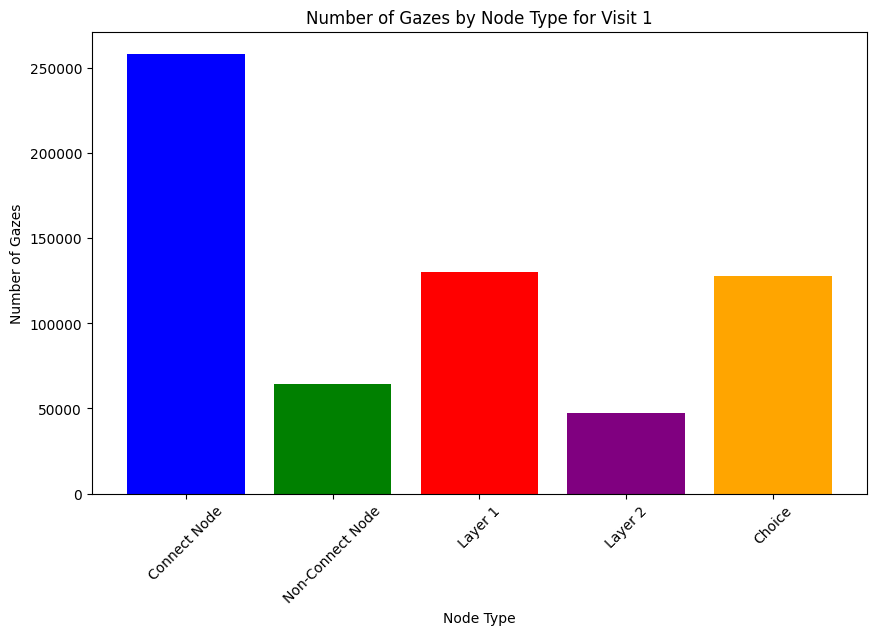

In [8]:

def plot_gaze(visit, df, accuracy=None):
    # Filter the DataFrame for the specified visit
    if accuracy is not None:
        df = df[df['accuracy'] == accuracy]
    
    df_visit = df[df['visit'] == visit]

    # Initialize the counts
    start_count = 0
    connect_node_count = 0
    non_connect_node_count = 0
    layer1_count = 0
    layer2_count = 0
    choice_count = 0

    # Sum the counts for each category
    for index, row in df_visit.iterrows():
        gaze_data = row['gaze']
        connect_nodes = row['connect_nodes']
        non_connect_nodes = row['non_connect_nodes']
        choice_nodes = row['choice']
        layer1_nodes = row['layer1']
        layer2_nodes = row['layer2']
       
        # Update counts based on the structure of gaze_data and node indices
        non_connect_node_count += sum(gaze_data.get(node, 0) for node in non_connect_nodes)
        connect_node_count += sum(gaze_data.get(node, 0) for node in connect_nodes)
        layer1_count += sum(gaze_data.get(node, 0) for node in layer1_nodes)
        layer2_count += sum(gaze_data.get(node, 0) for node in layer2_nodes)
        choice_count += sum(gaze_data.get(node, 0) for node in choice_nodes)

    categories = ['Connect Node', 'Non-Connect Node', 'Layer 1', 'Layer 2', 'Choice']
    counts = [connect_node_count, non_connect_node_count, layer1_count, layer2_count, choice_count]

    # Remove counts of -1
    categories, counts = zip(*[(cat, count) for cat, count in zip(categories, counts) if count != -1])
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title(f'Number of Gazes by Node Type for Visit {visit}')
    plt.xlabel('Node Type')
    plt.ylabel('Number of Gazes')
    plt.xticks(rotation=45)  # Rotate labels to improve readability
    plt.show()

plot_gaze(1, df)

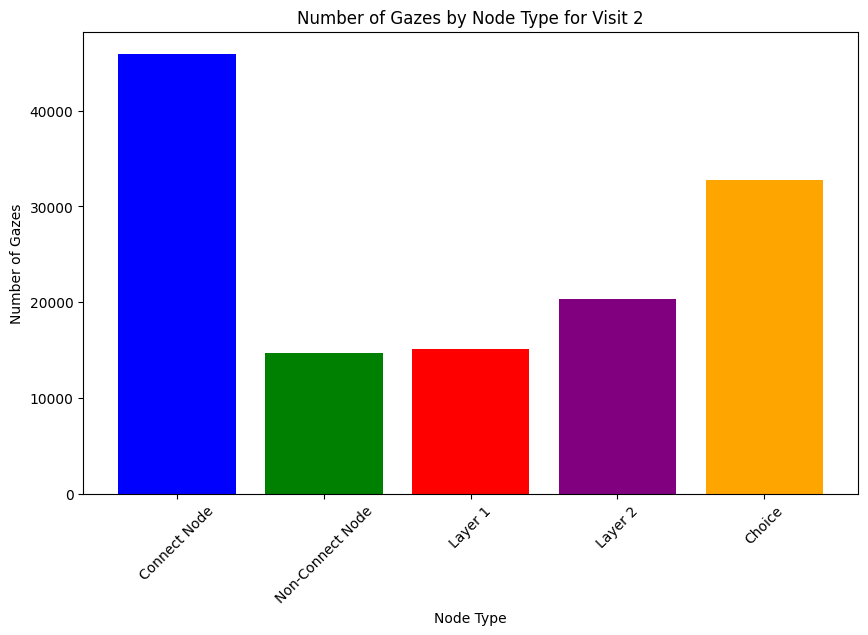

In [9]:
plot_gaze(2, df)

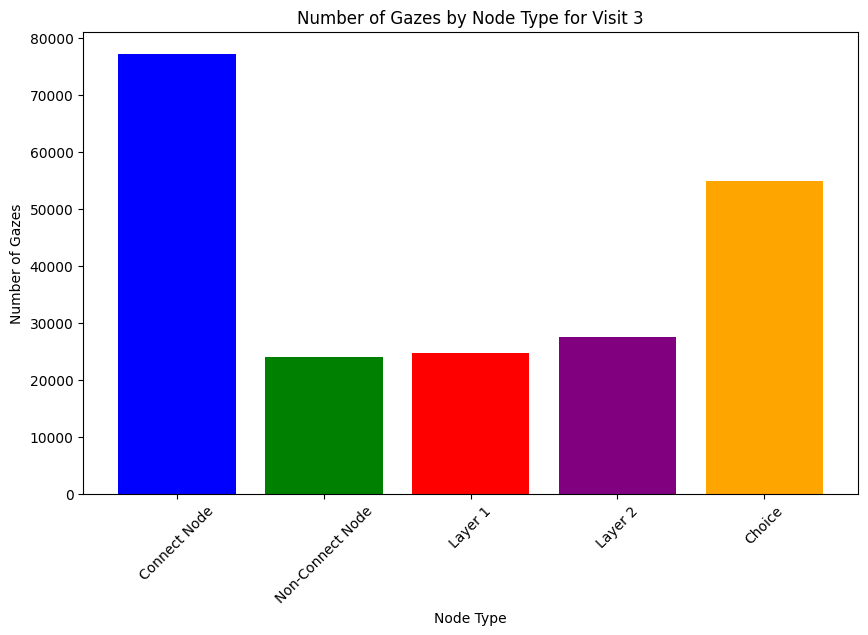

In [10]:
plot_gaze(3, df, accuracy=1)

In [11]:
def plot_gaze(trial_index, data_frame, node_positions, visit=None):
    """
    Plots the gaze data and node positions for a specific trial.
    """
    if visit == None:
        trial_data = data_frame[data_frame['trial_index'] == trial_index]
    else:
        trial_data = data_frame[data_frame['trial_index'] == trial_index][data_frame['visit'] == visit]

    # Prepare the figure and axis
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1280)
    ax.set_title(f'Gaze Plot for Trial Index {trial_index}')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')

    # Plot node positions directly without transformation
    for pos in node_positions:
        circle = Circle((pos[0], pos[1]), 2, color='red', fill=False, linewidth=1.5)
        ax.add_patch(circle)
        ax.scatter(*pos, color='red', s=100)
    
    if 'TimeEvent' in trial_data.columns and 'X' in trial_data.columns and 'Y' in trial_data.columns:
        # Normalize 'TimeEvent' for color mapping
        normalized_time = (trial_data['TimeEvent'] - trial_data['TimeEvent'].min()) / (trial_data['TimeEvent'].max() - trial_data['TimeEvent'].min())
        gaze_x = trial_data['X']
        gaze_y = trial_data['Y'] 
        cmap = plt.get_cmap('viridis')
        colors = cmap(normalized_time)
        scatter = ax.scatter(gaze_x, gaze_y, c=colors, edgecolor='k', label='Gaze Points', cmap='viridis', alpha=0.6)
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Relative Time')
    plt.show()

def plot_fixation(trial_index, data_frame, node_positions, visit=None):
    """
    Plots the gaze data and node positions for a specific trial.
    """
    if visit == None:
        trial_data = data_frame[data_frame['trial_index'] == trial_index]
    else:
        trial_data = data_frame[data_frame['trial_index'] == trial_index][data_frame['visit'] == visit]

    # Prepare the figure and axis
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1280)
    ax.set_title(f'Fixation Plot for Trial Index {trial_index}')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')



In [72]:
def plot_graph(trial_index,  node_positions , ax,data_frame=df,):
    trial_data = data_frame[data_frame['trial_index'] == trial_index].iloc[0]
    graph = trial_data['graph']
    start_node = trial_data['start']

    # Plot node positions directly without transformation
    for pos in node_positions:
        circle = Circle((pos[0], pos[1]), 30, color='red', fill=False, linewidth=1.5)
        ax.add_patch(circle)
        ax.scatter(*pos, color='red', s=100)

    # Plot edges between nodes
    for node_index, connections in enumerate(graph):
        if connections:
            for connected_node in connections:
                start_pos = node_positions[node_index]
                end_pos = node_positions[connected_node]
                ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-')

    # Highlight the start node
    start_pos = node_positions[start_node]
    ax.scatter(*start_pos, color='blue', s=200, label='Start Node', edgecolors='black')
    ax.legend()

    
def plot_eye_movement(trial_index, eye_data, trial_data, node_positions, visit=None):
    """
    Plots the gaze, fixation, and saccade data along with node positions for a specific trial.
    Filters out any data where node information is -1.
    """
    # Filter data by trial index and optionally by visit
    if visit is not None:
        trial_data = eye_data[(eye_data['trial_index'] == trial_index) & (eye_data['visit'] == visit)]
    else:
        trial_data = eye_data[eye_data['trial_index'] == trial_index]

    # Setup the plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1280)
    ax.set_title(f'Eye Movement Plot for Trial Index {trial_index} - Visit {visit}')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')

    plot_graph(trial_index, node_positions, ax=ax)

    # Plot gaze data
    # gaze_data = trial_data[(trial_data['Type'] == 'Gaze') & (trial_data['Node'] != -1)]
    gaze_data = trial_data[(trial_data['Type'] == 'Gaze')]
    ax.scatter(gaze_data['X'], gaze_data['Y'], color='blue', alpha=0.6, label='Gaze')

    # Plot fixation data
    fixation_data = trial_data[(trial_data['Type'] == 'Fixation')]
    for idx, fixation in fixation_data.iterrows():
        ax.scatter(fixation['X'], fixation['Y'], color='green', s=120, edgecolor='black', label='Fixation' if 'Fixation' not in ax.get_legend_handles_labels()[1] else "", marker='o')

    # Plot saccades as arrows, filtering out invalid start or end nodes
    saccade_data = trial_data[(trial_data['Type'] == 'Saccade')]
    for idx, saccade in saccade_data.iterrows():
        ax.arrow(saccade['Start_X'], saccade['Start_Y'], saccade['End_X'] - saccade['Start_X'], saccade['End_Y'] - saccade['Start_Y'], head_width=15, head_length=15, fc='orange', ec='orange', alpha=0.7, label='Saccade' if 'Saccade' not in ax.get_legend_handles_labels()[1] else "")

    # Adding legend
    ax.legend()
    plt.show()

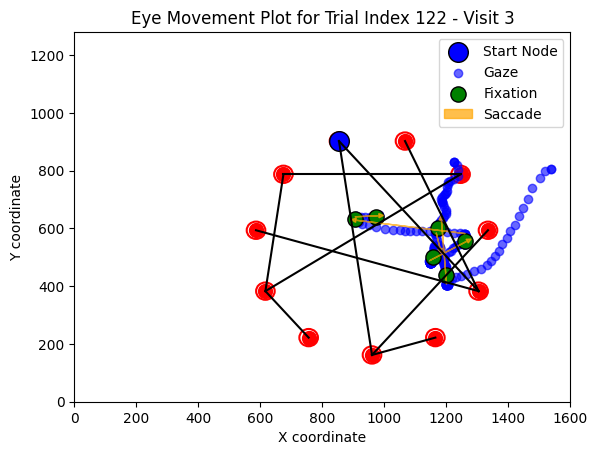

In [75]:

window_size = (1350, 750)  # Example window size
node_positions = [
    [960.0, 162.0], [755.6377710017841, 222.00616458981358], [616.159105755992, 382.97312508528694], 
    [585.8474949690074, 593.7950088673017], [674.3266608940903, 787.5373574313177], 
    [853.5050935139395, 902.68834402628], [1066.4949064860602, 902.68834402628], 
    [1245.6733391059095, 787.537357431318], [1334.1525050309926, 593.7950088673018], 
    [1303.840894244008, 382.97312508528705], [1164.3622289982159, 222.00616458981352]
]

# Example usage
# Visit 0 is drift check, Visit 1 is the first visit, Visit 2 is the second visit, Visit 3 is showing the choice
plot_eye_movement(trial_index=122, visit = 3, eye_data=eye_data, trial_data=df, node_positions=node_positions)


